# Introduction to GeoPandas

This quick tutorial provides an introduction to the key concepts of GeoPandas. In a few minutes, we'll describe the basics which allow you to start your projects.

## Concepts

GeoPandas, as the name suggests, extends popular data science library [pandas](https://pandas.pydata.org) by adding support for geospatial data. If you are not familiar with `pandas`, we recommend taking a quick look at its [Getting started documentation](https://pandas.pydata.org/docs/getting_started/index.html#getting-started) before proceeding.

The core data structure in GeoPandas is `geopandas.GeoDataFrame`, a subclass of `pandas.DataFrame` able to store geometry columns and perform spatial operations. Geometries are handled by `geopandas.GeoSeries` a subclass of `pandas.Series`. Therefore, your `GeoDataFrame` is a combination of `Series` with your data (numerical, boolean, text etc.) and `GeoSeries` with geometries (points, polygons etc.). You can have as many columns with geometries as you wish, there's no limit typical for desktop GIS software.

![geodataframe schema](../_static/dataframe.svg)

Each `GeoSeries` can contain any geometry type (we can even mix them within a single array) and has a `GeoSeries.crs` attribute, which stores information on the projection (CRS stands for Coordinate Reference System). Therefore, each `GeoSeries` in a `GeoDataFrame` can be in a different projection, allowing you to have, for example, multiple versions of the same geometry, just in a different CRS.

One `GeoSeries` within a `GeoDataFrame` is seen as _active_ geometry, which means that all geometric operations applied to a `GeoDataFrame` use the specified column.


<div class="alert alert-info">
User Guide
    
See more on [data structures in the User Guide](../docs/user_guide/data_structures.rst).
</div>


Let's see how this works in practice.

## Reading and writing files

First, we need to read some data.

### Read files

Assuming we have a file containing both data and geometry (e.g. GeoPackage, GeoJSON, Shapefile), we can easily read it using `geopandas.read_file` function, which automatically detects filetype and creates a `GeoDataFrame`. In this example, we'll use `"nybb"` dataset, a map of New York boroughs which is part of GeoPandas installation. Therefore we need to get the path to the actual file. With your file, you specify a path as a string (`"my_data/my_file.geojson"`).

In [74]:
import geopandas

path_to_data = geopandas.datasets.get_path("nybb")
gdf = geopandas.read_file(path_to_data)

gdf

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


### Write files

Writing a `GeoDataFrame` back to file is similarly simple, using `GeoDataFrame.to_file`. The default file format is Shapefile, but you can specify your own using `driver` keyword.

In [75]:
gdf.to_file("my_file.geojson", driver="GeoJSON")

<div class="alert alert-info">
User Guide
    
See more on [reading and writing data in the User Guide](../docs/user_guide/io.rst).
</div>



## Simple methods

Now we have our `GeoDataFrame` and can start working with its geometry. 

Since we have only one geometry column read from the file, it is automatically seen as the active geometry and methods used on `GeoDataFrame` will be applied to the `"geometry"` column.

### Measuring area

To measure the area of each polygon (or MultiPolygon in this specific case), we can use `GeoDataFrame.area` attribute, which returns a `pandas.Series`. Note that `GeoDataFrame.area` is just `GeoSeries.area` applied to an active geometry column.

But first, we set the names of boroughs as an index, to make the results easier to read.

In [76]:
gdf = gdf.set_index("BoroName")

In [77]:
gdf["area"] = gdf.area
gdf["area"]

BoroName
Staten Island    1.623822e+09
Queens           3.045214e+09
Brooklyn         1.937478e+09
Manhattan        6.364712e+08
Bronx            1.186926e+09
Name: area, dtype: float64

### Getting polygon boundary and centroid

To get just the boundary of each polygon (LineString), we can call `GeoDataFrame.boundary`.

In [78]:
gdf['boundary'] = gdf.boundary
gdf['boundary']

BoroName
Staten Island    MULTILINESTRING ((970217.022 145643.332, 97022...
Queens           MULTILINESTRING ((1029606.077 156073.814, 1029...
Brooklyn         MULTILINESTRING ((1021176.479 151374.797, 1021...
Manhattan        MULTILINESTRING ((981219.056 188655.316, 98094...
Bronx            MULTILINESTRING ((1012821.806 229228.265, 1012...
Name: boundary, dtype: geometry

Since we have saved boundary as a new column, we now have two geometry columns in the same `GeoDataFrame`.

We can also create new geometry, which could be, for example, a buffered version of the original one (i.e., `GeoDataFrame.buffer(10)`) or its centroid:

In [79]:
gdf['centroid'] = gdf.centroid
gdf['centroid']

BoroName
Staten Island     POINT (941639.450 150931.991)
Queens           POINT (1034578.078 197116.604)
Brooklyn          POINT (998769.115 174169.761)
Manhattan         POINT (993336.965 222451.437)
Bronx            POINT (1021174.790 249937.980)
Name: centroid, dtype: geometry

### Measuring distance

We can also measure how far is each centroid from the first one.

In [80]:
first_point = gdf['centroid'].iloc[0]
gdf['distance'] = gdf['centroid'].distance(first_point)
gdf['distance']

BoroName
Staten Island         0.000000
Queens           103781.535276
Brooklyn          61674.893421
Manhattan         88247.742789
Bronx            126996.283623
Name: distance, dtype: float64

## Making maps

GeoPandas can also plot maps, so we can check how our geometries look like in space. The key method here is `GeoDataFrame.plot`. In the example below, we plot the `"area"` we measured earlier using the active geometry column. We also want to show a legend (`legend=True`).

<AxesSubplot:>

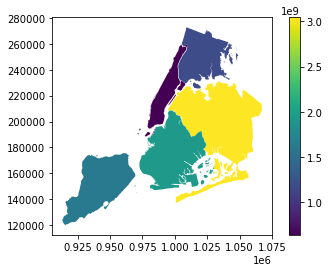

In [81]:
gdf.plot("area", legend=True)

Switching the active geometry (`GeoDataFrame.set_geometry`) to centroids, we can plot the same data using point geometry.

<AxesSubplot:>

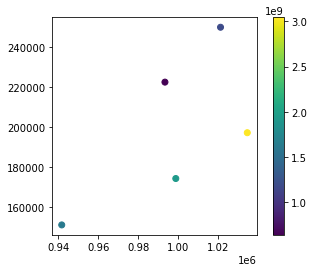

In [82]:
gdf = gdf.set_geometry("centroid")
gdf.plot("area", legend=True)

And we can also layer both `GeoSeries` on top of each other. We just need to use one plot as an axis for the other.

<AxesSubplot:>

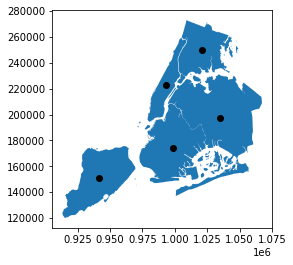

In [106]:
ax = gdf["geometry"].plot()
gdf["centroid"].plot(ax=ax, color="black")

Now we set the active geometry back to the original `GeoSeries`.

In [83]:
gdf = gdf.set_geometry("geometry")

<div class="alert alert-info">
User Guide
    
See more on [mapping in the User Guide](../docs/user_guide/mapping.rst).
</div>

## Geometry creation

We can further work with the geometry and create new shapes based on those we already have. 

### Convex hull

If we are interested in the convex hull of our polygons, we can call `GeoDataFrame.convex_hull()`.

In [98]:
gdf["convex_hull"] = gdf.convex_hull

<AxesSubplot:>

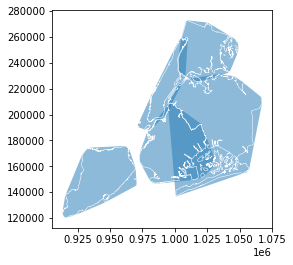

In [101]:
ax = gdf["convex_hull"].plot(alpha=.5)  # saving the first plot as an axis and setting alpha (transparency) to 0.5
gdf["boundary"].plot(ax=ax, color="white", linewidth=.5)  # passing the first plot and setting linewitdth to 0.5

### Buffer

In other cases, we may need to buffer the geometry using `GeoDataFrame.buffer()`. Geometry methods are automatically applied to the active geometry, but we can apply them directly to any `GeoSeries` as well. Let's buffer the boroughs and their centroids and plot both on top of each other.

In [85]:
# buffering the active geometry by 10 000 feet (geometry is already in feet)
gdf["buffered"] = gdf.buffer(10000)

# buffering the centroid geometry by 10 000 feet (geometry is already in feet)
gdf["buffered_centroid"] = gdf["centroid"].buffer(10000)

<AxesSubplot:>

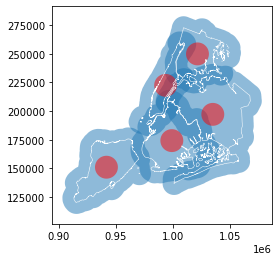

In [86]:
ax = gdf["buffered"].plot(alpha=.5)  # saving the first plot as an axis and setting alpha (transparency) to 0.5
gdf["buffered_centroid"].plot(ax=ax, color="red", alpha=.5)  # passing the first plot as an axis to the second
gdf["boundary"].plot(ax=ax, color="white", linewidth=.5)  # passing the first plot and setting linewitdth to 0.5

<div class="alert alert-info">
User Guide
    
See more on [geometry creation and manipulation in the User Guide](../docs/user_guide/geometric_manipulations.rst).
</div>

## Geometry relations

We can also ask about the relations of different geometries. Using the geometries above, we can check which of the buffered boroughs intersect the original geometry of Brooklyn, i.e., is within 10 000 feet from Brooklyn.

First, we get a polygon of Brooklyn.

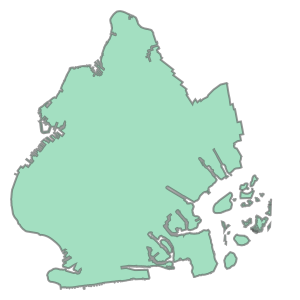

In [90]:
brooklyn = gdf.loc["Brooklyn", "geometry"]
brooklyn

In [104]:
type(brooklyn)

shapely.geometry.multipolygon.MultiPolygon

Then we can check which of the geometries in `gdf["buffered"]` intersects it.

In [91]:
gdf["buffered"].intersects(brooklyn)

BoroName
Staten Island     True
Queens            True
Brooklyn          True
Manhattan         True
Bronx            False
dtype: bool

Only Bronx (on the north) is more than 10 000 feet away from Brooklyn. All the others are closer and intersect our polygon.

Alternatively, we can check which buffered centroids are entirely within the original boroughs polygons. In this case, both `GeoSeries` are aligned, and the check is performed for each row.

In [92]:
gdf["within"] = gdf["buffered_centroid"].within(gdf)
gdf["within"]

BoroName
Staten Island     True
Queens            True
Brooklyn         False
Manhattan        False
Bronx            False
Name: within, dtype: bool

We can plot the results on the map to confirm the finding.

<AxesSubplot:>

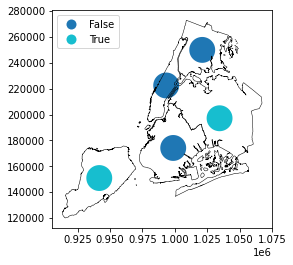

In [103]:
gdf = gdf.set_geometry("buffered_centroid")
ax = gdf.plot("within", legend=True, categorical=True, legend_kwds={'loc': "upper left"})  # using categorical plot and setting the position of the legend
gdf["boundary"].plot(ax=ax, color="black", linewidth=.5)  # passing the first plot and setting linewitdth to 0.5

## Projections

Each `GeoSeries` has (or should have) the Coordinate Reference System (CRS) accessible as `GeoSeries.crs`. CRS tells GeoPandas where the coordinates of geometries are located on the Earth. In some cases, CRS is geographic, which means that coordinates are in latitude and longitude. In those cases, its CRS is WGS84, with the authority code `EPSG:4326`. Let's see the projection of our NY boroughs `GeoDataFrame`.

In [95]:
gdf.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Geometries are in `EPSG:2263` with coordinates in feet. We can easily re-project a `GeoSeries` to another CRS, like `EPSG:4326` using `GeoSeries.to_crs()`.

<AxesSubplot:>

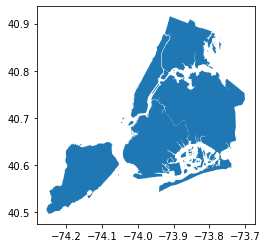

In [97]:
gdf = gdf.set_geometry("geometry")
boroughs_4326 = gdf.to_crs("EPSG:4326")
boroughs_4326.plot()

In [102]:
boroughs_4326.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Notice the difference in coordinates along the axes of the plot. Where we had 120 000 - 280 000 (feet) before, we have 40.5 - 40.9 (degrees) now. In this case, `boroughs_4326` has a `"geometry"` column in WGS84 but all the other (with centroids etc.) remains in the original CRS.

<div class="alert alert-warning">
Warning
    
For operations that rely on distance or area, you always need to use projected CRS (in meters, feet, kilometers etc.) not a geographic one. GeoPandas operations are planar, and degrees reflect the position on a sphere. Therefore the results may not be correct. 
</div>

<div class="alert alert-info">
User Guide
    
See more on [projections in the User Guide](../docs/user_guide/projections.rst).
</div>

## What next?

With GeoPandas we can do much more that this, from [aggregations](../docs/user_guide/aggregation_with_dissolve.rst), to [spatial joins](../docs/user_guide/mergingdata.rst), [geocoding](../docs/user_guide/geocoding.rst) and [much more](../gallery/index.rst).

Head to the [User Guide](../docs/user_guide.rst) for to learn more about different functionality of GeoPandas, to the [Examples](../gallery/index.rst) to see how it can be used or the the [API reference](../docs/reference.rst) for the details.